In [2]:
import pandas as pd
import numpy as np
import jsonlines
import leidenalg
import time
from tqdm import tqdm
from collections import defaultdict

# Load Publication Data from jsonlines file

In [3]:
publications = []
with jsonlines.open("./data/openalex_publications.jsonl") as f_in:
    for pub in f_in:
        publications.append(pub)
num_docs = len(publications)
num_docs

12706

# Bibliographic Coupling

Create a network were publications that cite the same papers are connected

Extract cited works from JSON data. Keep a count of the number of references in each publication.

In [4]:
cited_works = set()
cited_works_count = {}
for i, pub in enumerate(publications):
    cited_works_count[i] = len(pub.get('referenced_works'))
    for cited_work in pub['referenced_works']:
        cited_works.add(cited_work)
len(cited_works)

67113

Plot the distribution of reference counts.

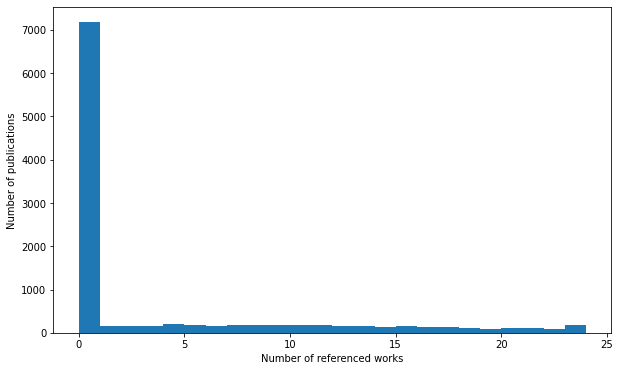

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(cited_works_count.values(), bins=np.arange(0,25,1))
ax.set_xlabel("Number of referenced works")
ax.set_ylabel("Number of publications")
plt.show()

From this we can see that many publications are not linked to any cited references (~7,000). In this case, we should expect to filter out some publications

Our reference matrix will consist of rows (publications) and columns (cited works). Values of 1 denote a reference from publication to cited work.

We first create an index mapping cited work urls to column numbers

In [7]:
cited_to_index = {}
index_to_cited = {}
for i, cited_work in enumerate(cited_works):
    cited_to_index[cited_work] = i
    index_to_cited[i] = cited_work

Create a sparse matrix of cited references

In [9]:
from scipy.sparse import csr_matrix

rows = []
cols = []
data = []

for i, pub in enumerate(publications):
    for cited_work in pub['referenced_works']:
        j = cited_to_index[cited_work]
        rows.append(i)
        cols.append(j)
        data.append(1)        

ref_matrix = csr_matrix((data, (rows, cols)), shape=(num_docs, len(cited_to_index)))        

Use cosine similarity to calculate bibliographic coupling between publications

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(ref_matrix, ref_matrix, dense_output=False)

# Run Leiden Algorithm 
Use the leiden algorithm to determine publication clusters.

The python implementation uses the Igraph library so we must extract the data in the correct format - edge_list and weight_list

We can ignore edges with cosine similarity < 0.1 as they will just increase the computational time without any benefit to quality

In [12]:
%%time
edge_list = []
weight_list = []
th = 0.1
rows,cols = (sim > th).nonzero()
for i,j in tqdm(zip(rows,cols), total=len(rows)):
    if i < j:
        edge_list.append((i, j))
        weight_list.append(sim[i,j])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131759/131759 [00:01<00:00, 91888.12it/s]

CPU times: user 1.51 s, sys: 56.3 ms, total: 1.57 s
Wall time: 1.56 s


In [13]:
import igraph as ig
graph = ig.Graph(edge_list, edge_attrs={"weight": weight_list})

Run the leiden algorithm 

In [14]:
partition = leidenalg.find_partition(
    graph,
    leidenalg.CPMVertexPartition,
    resolution_parameter=0.001,
    n_iterations=5,
    weights='weight',
    seed=42,
)

Populate a dict mapping doc_ids to leiden clusters.

Any publication assigned to a cluster with size < 50 are excluded.

Keep track of all publications that are clustered.

Also, sum the weights of concepts assigned to each publication in a cluster so we can make labels

In [15]:
leiden_clusters = {}
clustered_ids = set()
cluster_concept_weight = defaultdict(lambda: defaultdict(float))

for c, cluster_list in enumerate(partition):
    if len(cluster_list) < 50:
        c = -1
    else:
        for doc_id in cluster_list:
            leiden_clusters[doc_id] = c
            clustered_ids.add(doc_id)
            for concept in publications[doc_id]['concepts']:
                cluster_concept_weight[c][concept['display_name']] += 1

In [16]:
# show sizes of the largest clusters
df_cluster_sizes = pd.DataFrame.from_dict(leiden_clusters, orient='index').groupby(0).size()
df_cluster_sizes

0
0     853
1     735
2     322
3     159
4     145
5     125
6     123
7      72
8      71
9      68
10     66
11     64
12     62
13     57
14     53
15     51
16     50
dtype: int64

Calculate an indicative label based on the top 10 most frequently assigned concepts. 

In [17]:
cluster_labels = []

for cluster in df_cluster_sizes.index:
    idf_weights = [
        (concept, 
         (cluster_concept_weight[cluster][concept] / df_cluster_sizes.loc[cluster])
        )
        for concept in cluster_concept_weight[cluster]
        if cluster_concept_weight[cluster][concept] > 0
    ]
    label = " | ".join(["{} [{:.2f}]".format(concept, weight) for concept, weight in sorted(idf_weights, key=lambda x: x[1], reverse=True)[:10]])
    cluster_labels.append(label)

for i, label in enumerate(cluster_labels):
    print("{}\t[n={:,}] {}".format(i, df_cluster_sizes[i], label))

0	[n=853] Dengue fever [0.84] | Dengue virus [0.76] | Medicine [0.76] | Virology [0.40] | Outbreak [0.23] | Pediatrics [0.22] | Internal medicine [0.21] | Aedes aegypti [0.19] | Epidemiology [0.18] | Geography [0.15]
1	[n=735] Dengue fever [0.70] | Dengue virus [0.69] | Medicine [0.54] | Virology [0.44] | Outbreak [0.30] | Aedes aegypti [0.30] | Biology [0.26] | Environmental health [0.22] | Epidemiology [0.22] | Geography [0.20]
2	[n=322] Medicine [0.79] | Dengue fever [0.76] | Dengue virus [0.50] | Pediatrics [0.33] | Virology [0.32] | Internal medicine [0.23] | Dermatology [0.22] | Encephalitis [0.22] | Disease [0.21] | myalgia [0.13]
3	[n=159] Dengue fever [0.66] | Dengue virus [0.64] | Virology [0.51] | Basic reproduction number [0.49] | Transmission (telecommunications) [0.42] | Medicine [0.38] | Computer science [0.33] | Aedes aegypti [0.32] | Outbreak [0.27] | Epidemic model [0.26]
4	[n=145] Geography [0.66] | Dengue fever [0.65] | Dengue virus [0.57] | Outbreak [0.46] | Medici

If you ignore concepts relating specifically to dengue fever, you can get a sense of what certain clusters might be focussed on.

16 is focussed on the biology of the mosquito

4 is more epidemiology focussed



Use networkx library to build a network of publications with edges connecting nodes according to bibliographic coupling weight

In [19]:
import networkx as nx
graph = nx.Graph()

for doc_id in clustered_ids:
    oa_record = publications[doc_id]
    leiden_cluster = leiden_clusters[doc_id]

    attr = {
        'doc_id': doc_id,
        'doi': oa_record['doi'],
        'title': oa_record['display_name'],
        'publication_year': oa_record['publication_year'],
        'host_venue_name': oa_record['host_venue']['display_name'],
        'type': oa_record['type'],
        'cited_by_count': oa_record['cited_by_count'],
        'leiden_cluster': leiden_cluster,
        'cluster_label': cluster_labels[leiden_cluster],
    }
    # replace None with '' - gexf export doesn't like None values
    for key in ['doi', 'title', 'host_venue_name', 'type']:
        if not attr[key]:
            attr[key] = ''
    graph.add_node(doc_id, **attr)

In [20]:
for i in tqdm(clustered_ids):
    for j in sim[i,:].nonzero()[1]:
        if i < j and i in clustered_ids and j in clustered_ids and sim[i,j]>th:
            graph.add_edge(i,j, weight=sim[i,j])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3076/3076 [00:20<00:00, 151.46it/s]


In [21]:
print(graph.number_of_nodes())
print(graph.number_of_edges())

3076
55559


In [22]:
nx.write_gexf(graph, "./analysis/publication_bc_similarity.gexf")

Now load the data into Gephi to visualize the data

In [23]:
# write the cluster labels to a file
pd.DataFrame(cluster_labels, columns=['cluster_label']).to_csv("./data/leiden_cluster_labels.csv")

In [24]:
# write the doc_id -> cluster assigment to file
pd.DataFrame.from_dict(leiden_clusters, orient='index', columns=['leiden_cluster']).to_csv("./data/leiden_cluster_assignment.csv")